In [74]:
import numpy as np
import copy
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation
np.set_printoptions(threshold=np.infty)
from utils_data_elab import VIC_OFF_X, VIC_OFF_Y, get_scenes, scene, obstacle, run, get_obs_info, get_scene_index

import confidenceinterval as confint

from postproc_utils import list_dataset, \
    dict_dataset, \
    load_dataset, \
    open_json, \
    load_obstacles, \
    apply_rototranslation, \
    plot_scene, \
    plot_2dscene, \
    arena_filter, \
    obstacles_filter, \
    obstacles_filter2, \
    obstacles_filter3, \
    quad_dist2, \
    inside_walls, \
    keep_borders, \
    generate_abs_bounding_obstacle, \
    generate_abs_bounding_obstacles, \
    get_point_labels, \
    compute_distv1, \
    stack_labels_dists, \
    get_labels

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
# set axis label size to 25
mpl.rcParams['font.size'] = 25

path_to_json = "./data/"


# Load data

In [80]:


def unroll(data):
    ret = [x for x in data[0]]
    for i in range(1, len(data)):
        ret.append(data[i][-1])
    return np.array(ret)

rho = lambda x : np.linalg.norm(x, axis=-1)
phi = lambda x : np.arccos(x[:, :, 2] / rho(x[:, :, :3]))
theta = lambda x : np.arctan2(x[:, :, 1], x[:, :, 0])
to_spherical = lambda d: np.stack([rho(d[:, :, :3]), theta(d[:, :, :3]), phi(d[:, :, :3]), d[:, :, 3], d[:, :, 4]], axis=-1)


def plot_metric(model, run,  bin_size = 1, verbose=False):
    run_pred_fn = "./data/full_runs_prediction/"+model+"/full_run_pred_labels_run_"+run+".npy"
    run_labels_fn = "./data/full_runs_prediction/"+model+"/full_run_labels_labels_run_"+run+".npy"

    run_labels = np.load(run_labels_fn)
    run_labels = np.squeeze(run_labels)         # removing the last column

    run_pred = np.load(run_pred_fn)
    run_pred = np.argmax(run_pred, axis=-1)     # the predictions are actually probabilities --> argmax

    labelled_mmw = json.load(open(path_to_json+"/run_"+run+"/labelled_mmw_run_"+run+".json"))["labelled_mmw"]
    labelled_mmw_ = []
    for i in range(len(labelled_mmw)):
        for j in range(len(labelled_mmw[i])//200):
            labelled_mmw_.append(labelled_mmw[i][j*200:(j+1)*200])
    labelled_mmw = labelled_mmw_

    if verbose: print(" Shapes: ", run_labels.shape, run_pred.shape, len(labelled_mmw))

    unrolled_labels = unroll(run_labels)
    pos = np.stack(labelled_mmw[:len(unrolled_labels)])[:, :, :3]

    unrollled_pred = unroll(run_pred)

    data = np.stack([pos[:, :, 0], pos[:, :, 1], pos[:, :, 2], unrolled_labels, unrollled_pred], axis=-1)
    spherical_data = to_spherical(data)
    
    rho_min, rho_max = np.min(spherical_data[:, :, 0]), np.max(spherical_data[:, :, 0])

    rho_bins = np.arange(rho_min, rho_max, bin_size)
    if verbose: print("Rho bins: ", rho_bins)

    scores = []
    lows = []
    highs = []
    for i in range(len(rho_bins)-1):
        t_ = spherical_data[(spherical_data[:, :, 0] >= rho_bins[i]) & (spherical_data[:, :, 0] <= rho_bins[i+1])]
        score = confint.takahashi_methods.binary_f1_score_takahashi(t_[:, 3], t_[:, 4])
        scores.append(score[0])
        lows.append(score[1][0])
        highs.append(score[1][1])

        # print("Rho bin ", i, ": ", len(np.where((spherical_data[:, :, 0] >= rho_bins[i]) & (spherical_data[:, :, 0] <= rho_bins[i+1]))[0]))
    # len(np.where((spherical_data[:, :, 0] >= rho_bins[0]) & (spherical_data[:, :, 0] <= rho_bins[1]))[0])

    if verbose: print("Scores: ", scores)

    return rho_bins, scores, lows, highs


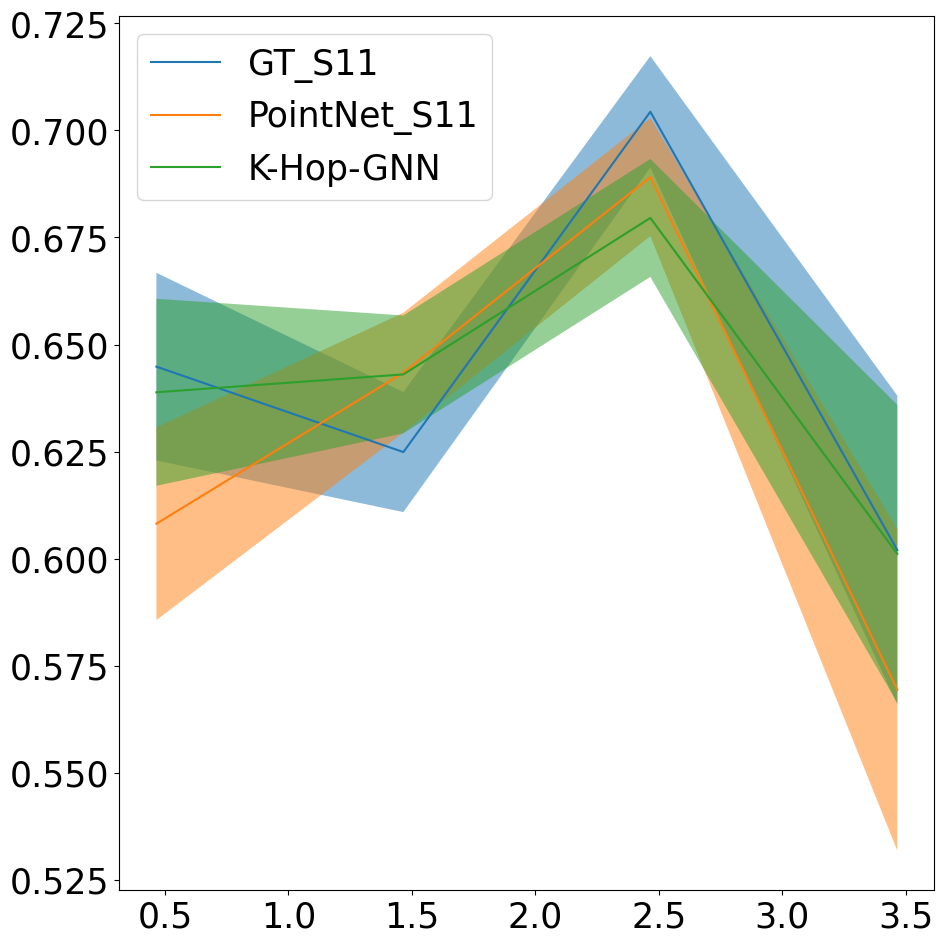

In [94]:
models = ["GT_S11", "PointNet_S11","K-Hop-GNN"]
runs = ["61", "61","61"]
bin_size=1

fig = plt.figure(figsize=(10, 10))
fig.set_tight_layout(True)

for model, run in zip(models, runs):
    rho_bins, scores, lows, highs = plot_metric(model, run, bin_size=bin_size, verbose=False)
    plt.plot(rho_bins[:-1], scores, label=model)
    plt.fill_between(rho_bins[:-1], lows, highs, alpha=0.5)

plt.legend()
